# L2 - Markov Localization

## Sense Function

In [15]:
#Modify the code below so that the function sense, which 
#takes p and Z as inputs, will output the NON-normalized 
#probability distribution, q, after multiplying the entries 
#in p by pHit or pMiss according to the color in the 
#corresponding cell in world.
import numpy as np
import math

p=[0.2, 0.2, 0.2, 0.2, 0.2]
world=['green', 'red', 'red', 'green', 'green']
measurements = ['red', 'green']
motions = [1,1]
pHit = 0.6
pMiss = 0.2
pExact = 0.8
pOvershoot = 0.1
pUndershoot = 0.1

def sense(p, Z):
    #
    #ADD YOUR CODE HERE
    #
    q = []
    n = len(p)
    for i in range(n):
        hit = (world[i] == Z)
        q.append(p[i]*hit*pHit + p[i]*(1-hit)*pMiss)
    return np.array(q)/sum(q) #normalize the probability

def move(p, U):
    '''
    #Method 1
    U = U % len(p)
    q = p[-U:]+p[:-U]
    '''
    #Method 2
    q = []
    n = len(p)
    U = U % n # count for the case when U > n
    for i in range(n):
        s = pExact * p[(i-U) % len(p)] # the probability of hit at exact location
        s = s+ pOvershoot * p[(i-U-1) % len(p)] # the ADDITIONAL probability of previous location overshooting
        s = s+ pUndershoot * p[(i-U+1) % len(p)] # the ADDITIONAL probability of latter location undershooting
        q.append(s)
    
    return q

       
def cal_entropy(p):
    sum = 0
    for i in range(len(p)):
        sum += -p[i]*math.log(p[i])
    return sum



for i in range(len(measurements)):
    print("i is ",i)
    p = sense(p,measurements[i])
    print("after sense() is ", np.round(np.array(p),2))
    p = move(p,motions[i])
    print("after move() is ", np.round(np.array(p),2))
    entropy = cal_entropy(p)
    print("entropy is {:.2f}".format(entropy))

print(p)

i is  0
after sense() is  [0.11 0.33 0.33 0.11 0.11]
after move() is  [0.11 0.13 0.31 0.31 0.13]
entropy is 1.51
i is  1
after sense() is  [0.16 0.06 0.15 0.44 0.19]
after move() is  [0.21 0.15 0.08 0.17 0.39]
entropy is 1.49
[0.21157894736842103, 0.1515789473684211, 0.08105263157894739, 0.16842105263157897, 0.3873684210526316]


## Moving Robot

In [30]:
# Make a robot called myrobot that starts at
# coordinates 30, 50 heading north (pi/2).
# Have your robot turn clockwise by pi/2, move
# 15 m, and sense. Then have it turn clockwise
# by pi/2 again, move 10 m, and sense again.
#
# Your program should print out the result of
# your two sense measurements.
#
# Don't modify the code below. Please enter
# your code at the bottom.

from math import *
import random



landmarks  = [[20.0, 20.0], [80.0, 80.0], [20.0, 80.0], [80.0, 20.0]]
world_size = 100.0


class robot:
    def __init__(self):
        self.x = random.random() * world_size
        self.y = random.random() * world_size
        self.orientation = random.random() * 2.0 * pi
        self.forward_noise = 0.0;
        self.turn_noise    = 0.0;
        self.sense_noise   = 0.0;
    
    def set(self, new_x, new_y, new_orientation):
        if new_x < 0 or new_x >= world_size:
            raise(ValueError, 'X coordinate out of bound')
        if new_y < 0 or new_y >= world_size:
            raise(ValueError, 'Y coordinate out of bound')
        if new_orientation < 0 or new_orientation >= 2 * pi:
            raise(ValueError, 'Orientation must be in [0..2pi]')
        self.x = float(new_x)
        self.y = float(new_y)
        self.orientation = float(new_orientation)
    
    
    def set_noise(self, new_f_noise, new_t_noise, new_s_noise):
        # makes it possible to change the noise parameters
        # this is often useful in particle filters
        self.forward_noise = float(new_f_noise);
        self.turn_noise    = float(new_t_noise);
        self.sense_noise   = float(new_s_noise);
    
    
    def sense(self):
        Z = []
        for i in range(len(landmarks)):
            dist = sqrt((self.x - landmarks[i][0]) ** 2 + (self.y - landmarks[i][1]) ** 2)
            dist += random.gauss(0.0, self.sense_noise)
            Z.append(dist)
        return Z
    
    
    def move(self, turn, forward):
        if forward < 0:
            raise(ValueError, 'Robot cant move backwards' )        
        
        # turn, and add randomness to the turning command
        orientation = self.orientation + float(turn) + random.gauss(0.0, self.turn_noise)
        orientation %= 2 * pi
        
        # move, and add randomness to the motion command
        dist = float(forward) + random.gauss(0.0, self.forward_noise)
        x = self.x + (cos(orientation) * dist)
        y = self.y + (sin(orientation) * dist)
        x %= world_size    # cyclic truncate
        y %= world_size
        
        # set particle
        res = robot()
        res.set(x, y, orientation)
        res.set_noise(self.forward_noise, self.turn_noise, self.sense_noise)
        return res
    
    def Gaussian(self, mu, sigma, x):
        
        # calculates the probability of x for 1-dim Gaussian with mean mu and var. sigma
        return exp(- ((mu - x) ** 2) / (sigma ** 2) / 2.0) / sqrt(2.0 * pi * (sigma ** 2))
    
    
    def measurement_prob(self, measurement):
        
        # calculates how likely a measurement should be
        
        prob = 1.0;
        for i in range(len(landmarks)):
            dist = sqrt((self.x - landmarks[i][0]) ** 2 + (self.y - landmarks[i][1]) ** 2)
            prob *= self.Gaussian(dist, self.sense_noise, measurement[i])
        return prob
    
    
    
    def __repr__(self):
        return '[x=%.6s y=%.6s orient=%.6s]' % (str(self.x), str(self.y), str(self.orientation))



def eval(r, p):
    sum = 0.0;
    for i in range(len(p)): # calculate mean error
        dx = (p[i].x - r.x + (world_size/2.0)) % world_size - (world_size/2.0)
        dy = (p[i].y - r.y + (world_size/2.0)) % world_size - (world_size/2.0)
        err = sqrt(dx * dx + dy * dy)
        sum += err
    return sum / float(len(p))



####   DON'T MODIFY ANYTHING ABOVE HERE! ENTER/MODIFY CODE BELOW ####
myrobot = robot()
myrobot = myrobot.move(0.1, 5.0)
Z = myrobot.sense()
N = 1000
T = 10 #Leave this as 10 for grading purposes.

p = []
for i in range(N):
    r = robot()
    r.set_noise(0.05, 0.05, 5.0)
    p.append(r)

print(eval(myrobot,p))    

for t in range(T):
    myrobot = myrobot.move(0.1, 5.0)
    Z = myrobot.sense()

    p2 = []
    for i in range(N):
        p2.append(p[i].move(0.1, 5.0))
    p = p2

    w = []
    for i in range(N):
        w.append(p[i].measurement_prob(Z))

    p3 = []
    index = int(random.random() * N)
    beta = 0.0
    mw = max(w)
    for i in range(N):
        beta += random.random() * 2.0 * mw
        while beta > w[index]:
            beta -= w[index]
            index = (index + 1) % N
        p3.append(p[index])
    p = p3
    
    #enter code here, make sure that you output 10 print statements.
    print(eval(myrobot,p))


37.99269394110318
5.019967831846634
4.860096548136288
5.197337322529889
4.772424587892289
4.565356817431595
4.414530270047625
4.419298852458449
4.2006782943448355
3.8027112348609426
3.445275200748555


# L5 - Implementation of a Particle Filter

## Calculate Prediction Step
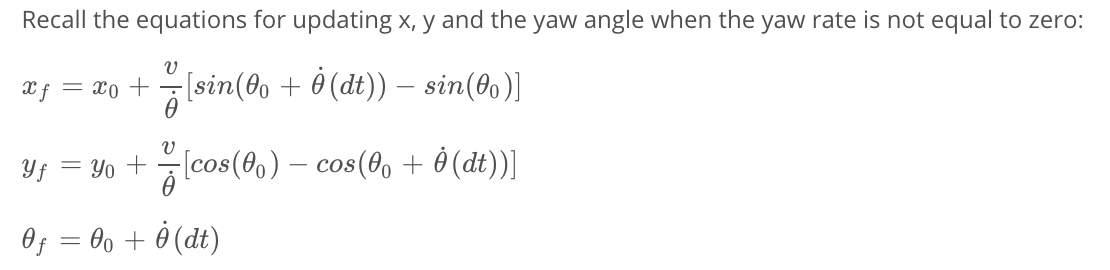

In [1]:
print(6.836448e-03 * 6.836448e-03 * 9.831849e-49)

4.59511335705704e-53
